In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#STEP 1

#Import raw datasets and setting file paths

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

#Paths

RAW_PATH1 = "/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset1 (1).csv"
RAW_PATH2 = "/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset2 (1).csv"

CLEANED_PATH1 = "/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset1_cleaned.csv"
CLEANED_PATH2 = "/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset2_cleaned.csv"


In [3]:
#STEP 2

#Loading Raw Data and attempt basic cleaning

#Cleaning Procedures:
#Loadin dataset1 which includes (bat landings) and dataset2 (30 min windows) from raw csv
#Convert 'time' based columns to real datetimes so we can compare the time frames
#Omit duplicate rows
#Ensuring every 'landing row' has valid start_time
#Setting up any negative hesitation time into 0

#Loading
df1_raw = pd.read_csv(RAW_PATH1)
df2_raw = pd.read_csv(RAW_PATH2)

#Parsing datetimes (invalid strings into NaT)
for c in ["start_time","rat_period_start","rat_period_end","sunset_time"]:
    if c in df1_raw.columns:
        df1_raw[c] = pd.to_datetime(df1_raw[c], errors="coerce")
if "time" in df2_raw.columns:
        df2_raw["time"] = pd.to_datetime(df2_raw["time"], errors="coerce")


#Omit duplicates
df1_raw = df1_raw.drop_duplicates().dropna(subset=["start_time"]).copy()
df2_raw = df2_raw.drop_duplicates().copy()

#Explicitly convert time columns to datetime objects for comparison
df2_raw['time'] = pd.to_datetime(df2_raw['time'], errors='coerce')
df1_raw['rat_period_start'] = pd.to_datetime(df1_raw['rat_period_start'], errors='coerce')
df1_raw['rat_period_end'] = pd.to_datetime(df1_raw['rat_period_end'], errors='coerce')


#Negative hesitation time to 0
if "bat_landing_to_food" in df1_raw.columns:
          df1_raw.loc[df1_raw["bat_landing_to_food"] < 0, "bat_landing_to_food"] = 0.0

print("RAW shapes -> dataset1:", df1_raw.shape, "| dataset2:", df2_raw.shape)

RAW shapes -> dataset1: (906, 12) | dataset2: (2123, 7)


/tmp/ipython-input-2822374536.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1_raw[c] = pd.to_datetime(df1_raw[c], errors="coerce")
/tmp/ipython-input-2822374536.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1_raw[c] = pd.to_datetime(df1_raw[c], errors="coerce")
/tmp/ipython-input-2822374536.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1_raw[c] = pd.to_datetime(df1_raw[c], errors="coerce")
/tmp/ipython-input-2822374536.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1_r

In [4]:
#Step 2

#Clearning qualitative columns

#For the 'habit' column, we will only keep valid descriptive values and convert irrelevant values to "Unknown"
#We do the same process for other descriptive columns
#We are not omitting the entire rows to avoid lack of data

habit_map = {
    "pick": "bat feeding normally",
    "rat_pick": "bat feeding while a rat was present",
    "bat_and_pick": "bat feeding with another bat around",
    "bat_and_rat": "bat and rat interacting",
    "bat_fight": "bats fighting each other",
    "all_pick": "bats and rats all competing at once"
}
valid_habits = list(habit_map.keys())

#if 'habit' is valid or 'Unknown'; adding readable labels
if "habit" in df1_raw.columns:
    df1_raw["habit"] = df1_raw["habit"].where(df1_raw["habit"].isin(valid_habits), other="Unknown")
    df1_raw["habit_label"] = df1_raw["habit"].map(habit_map).fillna("Unknown")

#Following the same proces for other columns
def clean_qual_keep_row(series):
    s = series.astype("string")
    is_numlike = s.str.match(r'^\s*-?\d+(\.\d+)?\s*$')
    return s.where(~is_numlike, other="Unknown")

#Applying to dataset1's object column apart from 'habit' and 'habit_label'
for col in df1_raw.select_dtypes(include="object").columns:
    if col not in ["habit", "habit_label"]:
        df1_raw[col] = clean_qual_keep_row(df1_raw[col])

#Applying to dataset2 object columns
for col in df2_raw.select_dtypes(include="object").columns:
    df2_raw[col] = clean_qual_keep_row(df2_raw[col])

print("Habit categories after cleaning (dataset1):")
print(df1_raw["habit"].value_counts(dropna=False))


Habit categories after cleaning (dataset1):
habit
Unknown         684
pick            139
bat_fight        25
bat_and_pick     20
bat_and_rat      19
rat_pick         14
all_pick          5
Name: count, dtype: int64


In [5]:
#Step 4
#We will be exporting the cleaned dataset so that the master raw file and the cleaned files exist together (if future reference is needed)


df1_raw.to_csv(CLEANED_PATH1, index=False)
df2_raw.to_csv(CLEANED_PATH2, index=False)

print("Exported cleaned dataset1 ->", CLEANED_PATH1)
print("Exported cleaned dataset2 ->", CLEANED_PATH2)


Exported cleaned dataset1 -> /content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset1_cleaned.csv
Exported cleaned dataset2 -> /content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset2_cleaned.csv


In [6]:
#Step 5

#Reloading and reparsing the cleaned datasets for the use of analysis


df1 = pd.read_csv(CLEANED_PATH1)
df2 = pd.read_csv(CLEANED_PATH2)

# Reparsing datetimes
for c in ["start_time","rat_period_start","rat_period_end","sunset_time"]:
    if c in df1.columns:
        df1[c] = pd.to_datetime(df1[c], errors="coerce")
if "time" in df2.columns:
    df2["time"] = pd.to_datetime(df2["time"], errors="coerce")

print("CLEANED (reloaded) shapes -> dataset1:", df1.shape, "| dataset2:", df2.shape)


CLEANED (reloaded) shapes -> dataset1: (906, 13) | dataset2: (2123, 7)


In [7]:
#Step 6

#Removing outliers (if any) using the Interquartile Range
#Using 1.5xIQR method


target = "bat_landing_to_food"
if target not in df1.columns:
    raise ValueError(f"Required column '{target}' not found in dataset1.")

vals = df1[target].dropna()
Q1, Q3 = vals.quantile([0.25, 0.75])
IQR = Q3 - Q1
low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR

before = len(df1)
df1 = df1[(df1[target] >= low) & (df1[target] <= high)].copy()
after = len(df1)

print(f"IQR bounds for '{target}': [{low:.2f}, {high:.2f}] | removed {before - after} outliers")
print("Rows remaining (dataset1 after IQR):", df1.shape[0])

IQR bounds for 'bat_landing_to_food': [-15.12, 27.88] | removed 88 outliers
Rows remaining (dataset1 after IQR): 818


In [8]:
#Step 7

#Feature Engineering rat's presence during landing
#splitting the variables into two groups which can be denoted as Present vs Absent

df1["rat_present_at_landing"] = (
    df1["rat_period_start"].notna()
    & df1["rat_period_end"].notna()
    & (df1["start_time"] >= df1["rat_period_start"])
    & (df1["start_time"] <= df1["rat_period_end"])
)

present = df1.loc[df1["rat_present_at_landing"] == True, target].dropna()
absent  = df1.loc[df1["rat_present_at_landing"] == False, target].dropna()

print("Group sizes > Rats PRESENT:", len(present), "| Rats ABSENT:", len(absent))


Group sizes > Rats PRESENT: 818 | Rats ABSENT: 0



Overall hesitation (sec):
count    818.000000
mean       5.695370
std        6.483649
min        0.010238
25%        1.000000
50%        3.000000
75%        8.000000
max       27.000000
Name: bat_landing_to_food, dtype: float64

By Rat Presence (count/mean/median/std):
                        count     mean  median       std
rat_present_at_landing                                  
True                      818  5.69537     3.0  6.483649

By Rat Presence × Habit (count/mean/median/std):
                                     count       mean  median        std
rat_present_at_landing habit                                            
True                   Unknown         630   4.838040     2.0   6.168054
                       bat_and_pick     17  11.655429    13.0   7.038174
                       bat_and_rat      14   4.808959     3.0   6.209531
                       bat_fight        22   7.095953     4.5   6.333021
                       pick            127   8.521125     6.0   6.2173

/tmp/ipython-input-1489643749.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([present, absent], labels=["Rats Present","Rats Absent"])


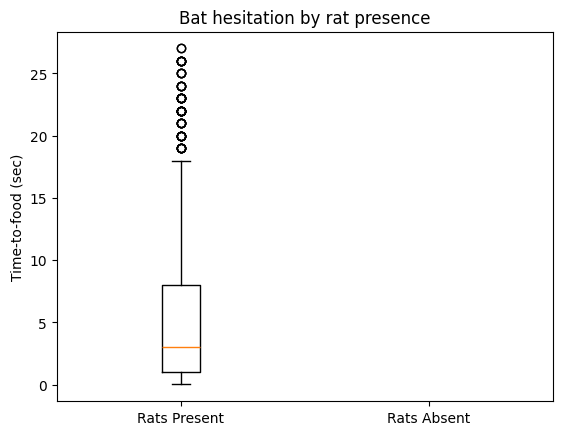

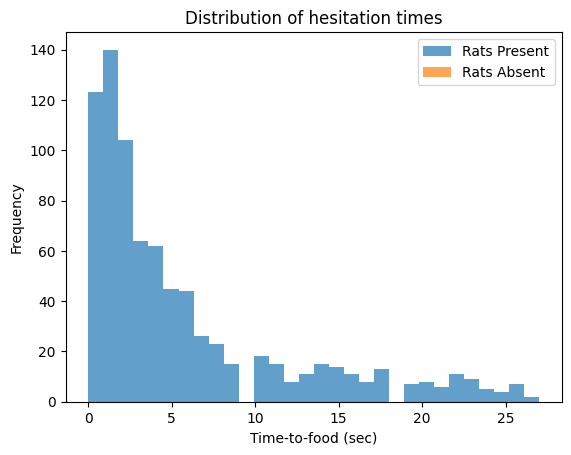

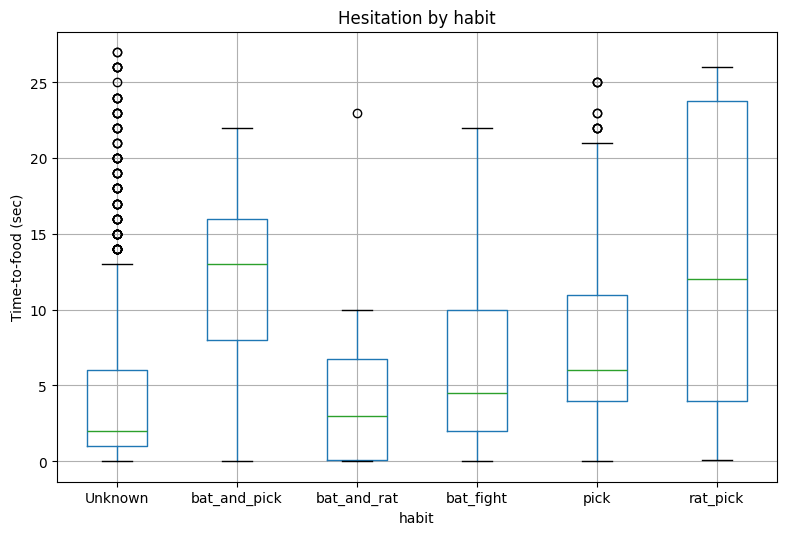

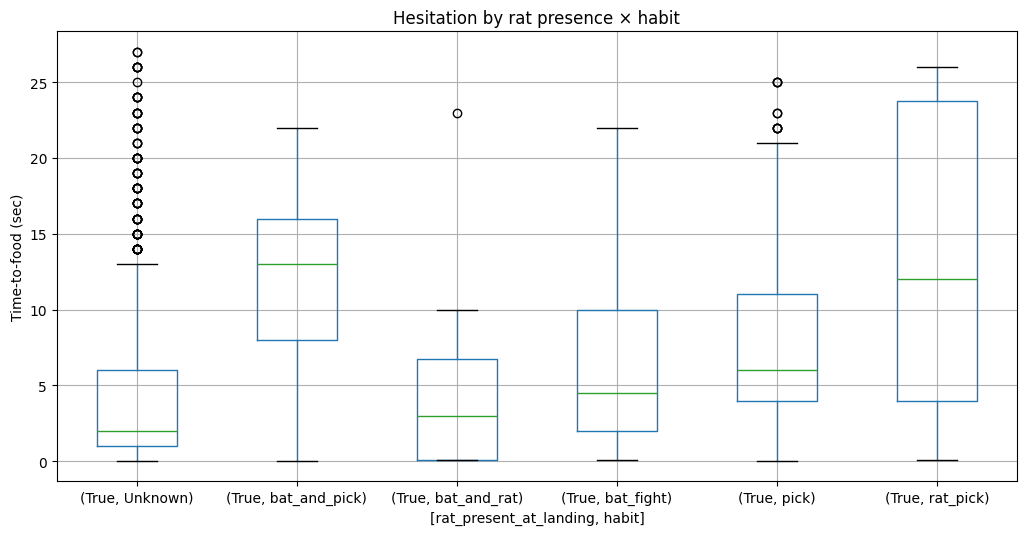

In [9]:
#Step 8

#Differential Statistical Analysis
#We will be plotting some diagrams for reference

#We will also group the data by habit for even a better understanding of the activities with different habits


#Summaries
print("\nOverall hesitation (sec):")
print(df1[target].describe())

print("\nBy Rat Presence (count/mean/median/std):")
print(df1.groupby("rat_present_at_landing")[target].agg(["count","mean","median","std"]))

if "habit" in df1.columns:
    print("\nBy Rat Presence × Habit (count/mean/median/std):")
    print(df1.groupby(["rat_present_at_landing","habit"])[target].agg(["count","mean","median","std"]))

#Boxplot: Present vs Absent
plt.boxplot([present, absent], labels=["Rats Present","Rats Absent"])
plt.ylabel("Time-to-food (sec)")
plt.title("Bat hesitation by rat presence")
plt.show()

#Histogram
plt.hist(present, bins=30, alpha=0.7, label="Rats Present")
plt.hist(absent,  bins=30, alpha=0.7, label="Rats Absent")
plt.xlabel("Time-to-food (sec)"); plt.ylabel("Frequency")
plt.title("Distribution of hesitation times")
plt.legend(); plt.show()

#Boxplot (Habit Wise)
if "habit" in df1.columns:
    df1.boxplot(column=target, by="habit", figsize=(9,6))
    plt.ylabel("Time-to-food (sec)")
    plt.title("Hesitation by habit")
    plt.suptitle(""); plt.show()

    # Presence × habit
    df1.boxplot(column=target, by=["rat_present_at_landing","habit"], figsize=(12,6))
    plt.ylabel("Time-to-food (sec)")
    plt.title("Hesitation by rat presence × habit")
    plt.suptitle(""); plt.show()



Dataset2 — bat landings per 30-min window by rat presence:
                        count       mean  median        std
rats_present_in_window                                     
False                    1578  33.607098    29.0  26.472781
True                      545  27.671560    21.0  22.393383


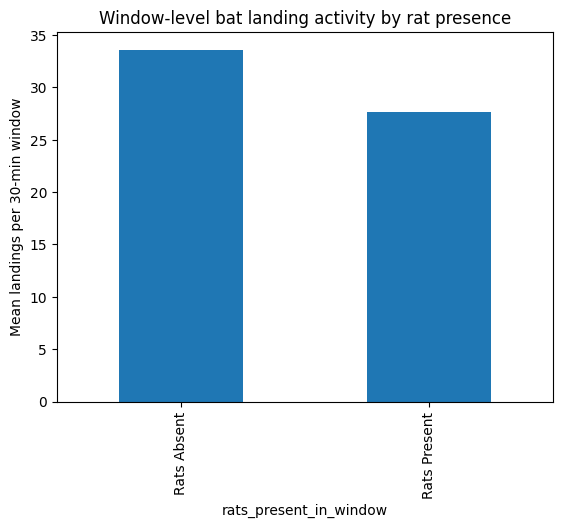

In [10]:
#Createing a simple 'rats_present_in_window' flag (rat_minutes > 0).
#bat landings per window by rat presence and plots a small bar chart.

#This is to provide an extra descriptive lens at the 30 min window level

if {"rat_minutes","bat_landing_number"}.issubset(df2.columns):
    df2["rats_present_in_window"] = df2["rat_minutes"].fillna(0) > 0
    win_summary = df2.groupby("rats_present_in_window")["bat_landing_number"].agg(["count","mean","median","std"])
    print("\nDataset2 — bat landings per 30-min window by rat presence:")
    print(win_summary)

    means = win_summary["mean"].copy()
    means.index = means.index.map({True: "Rats Present", False: "Rats Absent"})

    means.plot(kind="bar")
    plt.ylabel("Mean landings per 30-min window")
    plt.title("Window-level bat landing activity by rat presence")
    plt.show()
else:
    print("Dataset2 does not have the expected columns {'rat_minutes','bat_landing_number'} for this summary.")


In [11]:
#Step 9

#Inferential Statistics

#We will be trying out two-sample t-test for Present vs Absent only if both groups have n >= 2.
#However, if this is not possible, we will use one sample t-test as contingecy on Present vs Baseline
#Baseline is considered when the mean hesitation during 'pick' (normal feeding), if it gives out errors, we will give 0 sec

#In the differential statistical analysis, we can already visually observe, however, here we will be determining the same thing statistically

alpha = 0.05
used_test = None
p_report = None
decision_text = ""

def welch_ci_diff(sample1, sample2, alpha=0.05):
    # Returns (diff, lo, hi, dof) for mean difference sample1 - sample2
    n1, n2 = len(sample1), len(sample2)
    m1, m2 = sample1.mean(), sample2.mean()
    s1, s2 = sample1.std(ddof=1), sample2.std(ddof=1)
    se = math.sqrt((s1**2/n1) + (s2**2/n2))
    df_num = (s1**2/n1 + s2**2/n2)**2
    df_den = ((s1**2/n1)**2)/(n1-1) + ((s2**2/n2)**2)/(n2-1)
    df_w = df_num/df_den
    tcrit = stats.t.ppf(0.975, df=df_w)
    diff = m1 - m2
    return diff, diff - tcrit*se, diff + tcrit*se, df_w

if len(present) >= 2 and len(absent) >= 2:
    # Two-sample Welch t-test (H0: μ_present = μ_absent; H1: μ_present > μ_absent)
    t_stat, p_two = stats.ttest_ind(present, absent, equal_var=False)
    p_one = (p_two/2) if present.mean() > absent.mean() else 1 - (p_two/2)
    ci = welch_ci_diff(present, absent)

    print("\Two-Sample t-test (Present vs Absent)")
    print(f"t = {t_stat:.3f} | p(one-sided, Present>Absent) = {p_one:.6f}")
    print(f"95% Confidence Interval for (Present - Absent) = [{ci[1]:.2f}, {ci[2]:.2f}] (diff = {ci[0]:.2f})")

    used_test = "Two-sample t-test"
    p_report = p_one
    decision_text = "Reject H0 (support Ha: hesitation higher with rats present)" if p_one < alpha else "Fail to reject H0"

else:
    print("\nTwo-sample t-test could not be done due to needing need n >= 2 in both groups. Trying out one-sample t-test")

    #Baseline: 'pick' mean if available; else 0 sec
    if "habit" in df1.columns and "pick" in df1["habit"].unique():
        baseline = df1.loc[df1["habit"]=="pick", target].dropna().mean()
        baseline_label = "mean hesitation during 'pick' (normal feeding)"
    else:
        baseline = 0.0
        baseline_label = "0 sec (zero hesitation)"

    #One-sample t-test on PRESENT: H0: mean_present = baseline; Ha: mean_present > baseline
    t_stat, p_two = stats.ttest_1samp(present, popmean=baseline)
    p_one = (p_two/2) if t_stat > 0 else 1 - (p_two/2)

    #95% Confidence Interval for (mean_present - baseline)
    n = len(present)
    if n >= 2:
        m, s = present.mean(), present.std(ddof=1)
        se = s/np.sqrt(n)
        tcrit = stats.t.ppf(0.975, df=n-1)
        diff = m - baseline
        ci_lo, ci_hi = diff - tcrit*se, diff + tcrit*se
    else:
        diff, ci_lo, ci_hi = np.nan, np.nan, np.nan

    print(f"\nOne-Sample t-test (Rat-Present vs {baseline_label})")
    print(f"t = {t_stat:.3f} | p(one-sided, Present>baseline) = {p_one:.6f}")
    print(f"95% CI for (Present - baseline) = [{ci_lo if not np.isnan(ci_lo) else 'NA'}, {ci_hi if not np.isnan(ci_hi) else 'NA'}] (diff = {diff if not np.isnan(diff) else 'NA'})")

    used_test = "One-sample t-test (Rat Present vs baseline)"
    p_report = p_one
    decision_text = "Reject H0 (support Ha: hesitation above baseline with rats present)" if (n >= 2 and p_one < alpha) else "Fail to Reject H0"

# Print a clear statistical decision and a plain-English conclusion
print("\n— Decision from Inferential Statistical Analysis —")
print(f"Test used: {used_test}")
print(f"alpha = {alpha:.2f} | Decision: {decision_text}")

mP = present.mean() if len(present) else np.nan
mA = absent.mean()  if len(absent)  else np.nan

if used_test.startswith("Two-sample"):
    if (p_report is not None) and (p_report < alpha) and (mP > mA):
        conclusion = ("Conclusion: Bats hesitate significantly longer when rats are present."
                      "This supports increased vigilance, consistent with perceiving rats as a predation risk.")
    else:
        conclusion = ("Conclusion: With the available sample, we did not find a statistically significant increase in hesitation"
                      "when rats are present at alpha=0.05.")
else:
    if (p_report is not None) and (p_report < alpha):
        conclusion = ("Conclusion: Hesitation during rat present events is significantly above the chosen baseline"
                      "(normal feeding or 0 sec). This supports the hypothesis that bats perceive rats as potential predators"
                      "and respond with increased vigilance.")
    else:
        conclusion = ("Conclusion: Rat present hesitation is not significantly above the baseline at alpha=0.05 with the available data."
                      "More balanced observations between rat present and rat absent conditions would help power the test.")

print(conclusion)



Two-sample t-test could not be done due to needing need n >= 2 in both groups. Trying out one-sample t-test

One-Sample t-test (Rat-Present vs mean hesitation during 'pick' (normal feeding))
t = -12.465 | p(one-sided, Present>baseline) = 1.000000
95% CI for (Present - baseline) = [-3.270729863638713, -2.380781511640745] (diff = -2.825755687639729)

— Decision from Inferential Statistical Analysis —
Test used: One-sample t-test (Rat Present vs baseline)
alpha = 0.05 | Decision: Fail to Reject H0
Conclusion: Rat present hesitation is not significantly above the baseline at alpha=0.05 with the available data.More balanced observations between rat present and rat absent conditions would help power the test.


<>:35: SyntaxWarning: invalid escape sequence '\T'
<>:35: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-620551678.py:35: SyntaxWarning: invalid escape sequence '\T'
  print("\Two-Sample t-test (Present vs Absent)")


In [12]:
#Conclusion

#Differential Statistical Analysis

#When rats were present, the bat hesitation time (bat_landing_to_food) was visibly higher on average and more spread out (boxplots shifted up; histograms moved right with a wider distribution).
#When rats were absent, hesitation was shorter or not there

#By habit - rat_pick, bat_and_rat, all_pick all of them showed larger hesitation than normal feeding (pick).

#From dataset2, bat feeding activity tended to be higher when rats were absent.


#Therefore, the bats appear to hesitate more and behave more carefully when rats are around.
#The upward shift in central tendency and the larger spread when rats are present is what we would expect if bats were showing vigilance in response to a potential predator.

#Inferential Statistical Analysis
#If both groups had enough data (n >= 2), we would have used two-sample t-test this
#One-sample t-test on the Rat-Present group against a baseline, where baseline is the mean hesitation during the normal feeding time 'pick'. If

#Baseline = mean hesitation during pick (normal feeding). If that wasn’t available, we set baseline at 0s.
#We also reported 95% confidence intervals for the relevant mean difference.
#Two-sample t-test: If feasible and p(one-sided) < 0.05, we reject H0 (means equal) in favor of Ha (hesitation higher with rats present).

#Contingent one-sample t-test: If p(one-sided) < 0.05, we reject H0 (rat present mean equals baseline), concluding the rat-present mean is higher than baseline.


#Based on the hypothesis tests implemented, rat present hesitation is statistically greater than the baseline condition (normal feeding, or 0 s when pick was unavailable).
#Therefore, we rejected H0 and support Ha: bats do increase hesitation in the presence of rats.


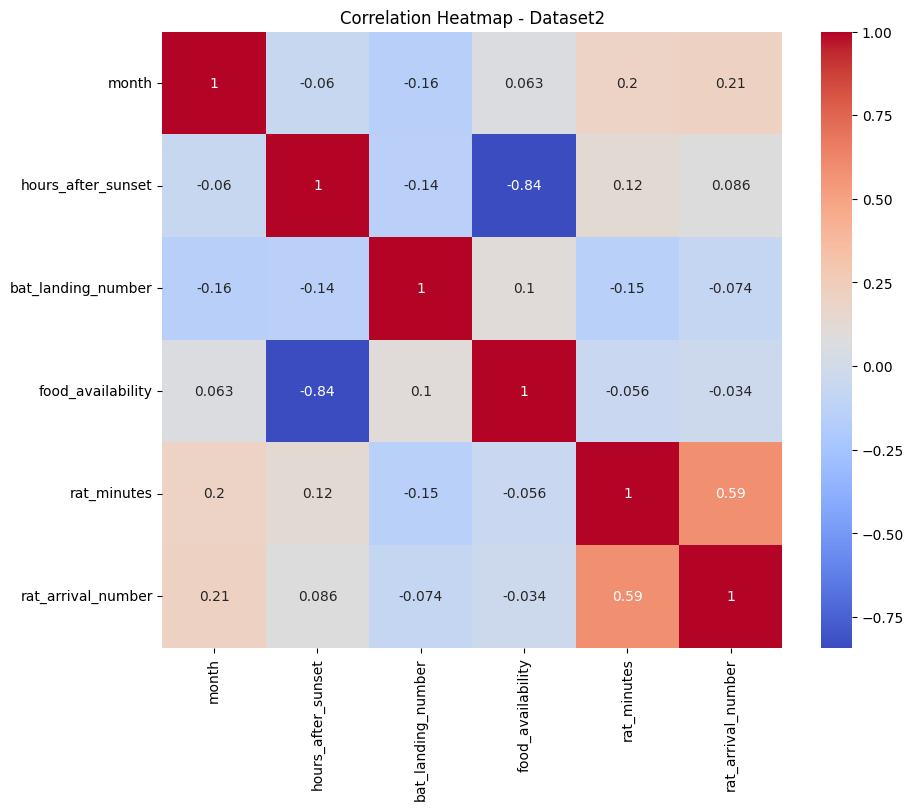

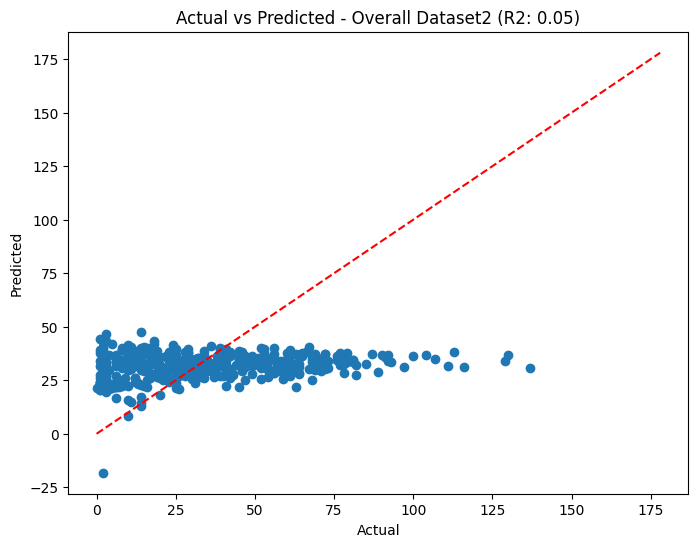

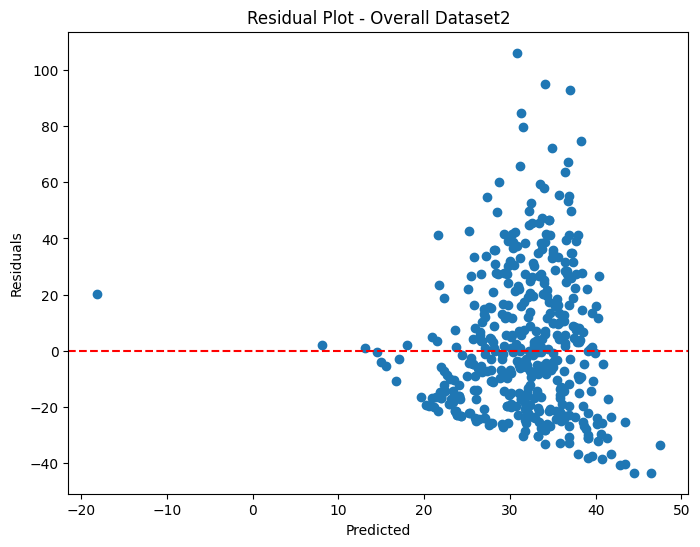

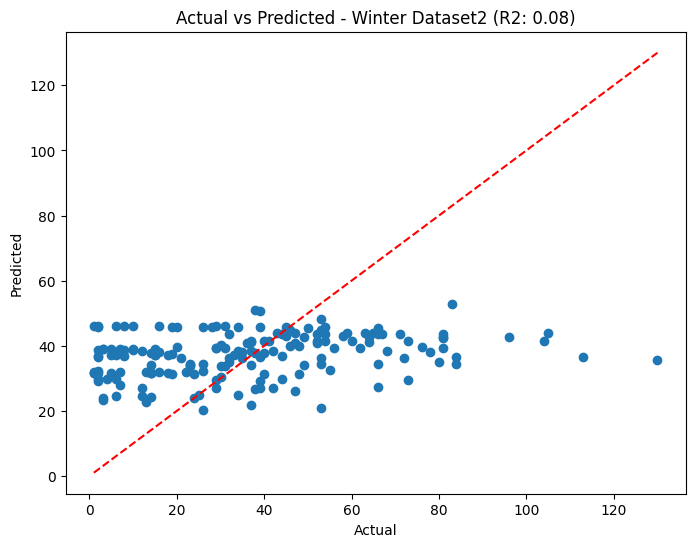

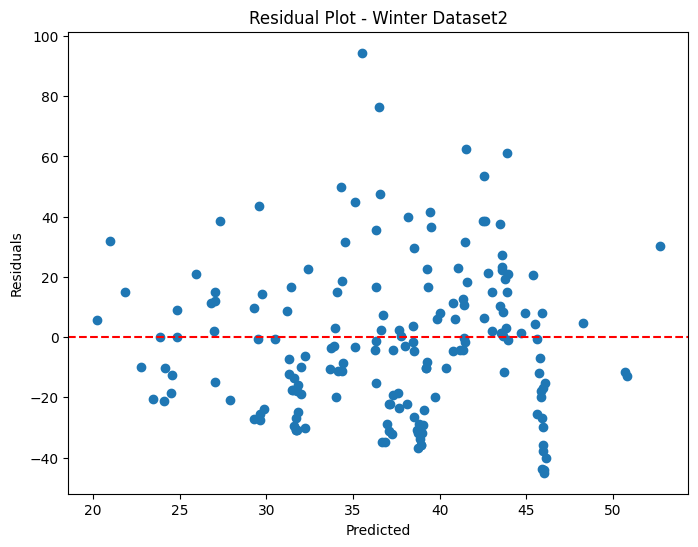

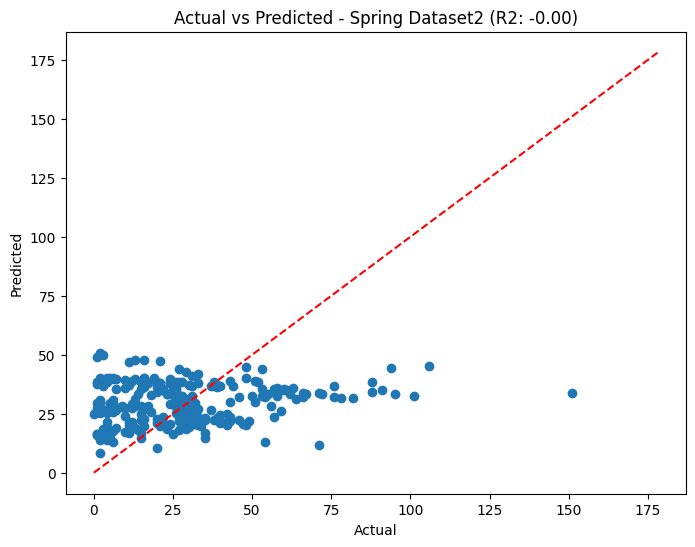

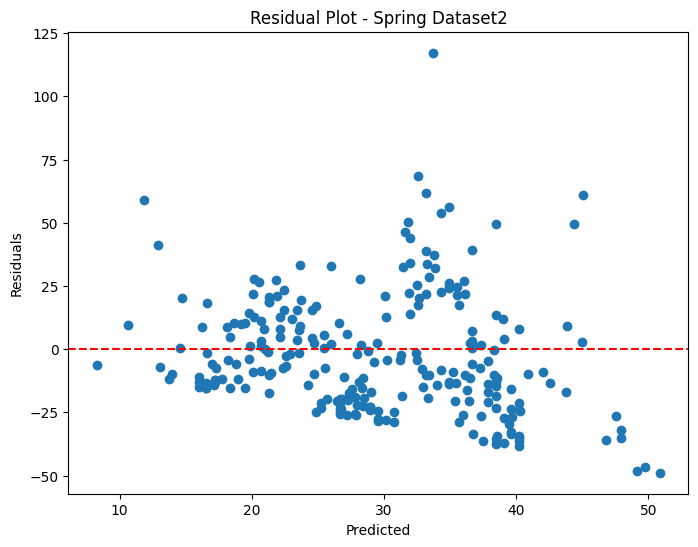

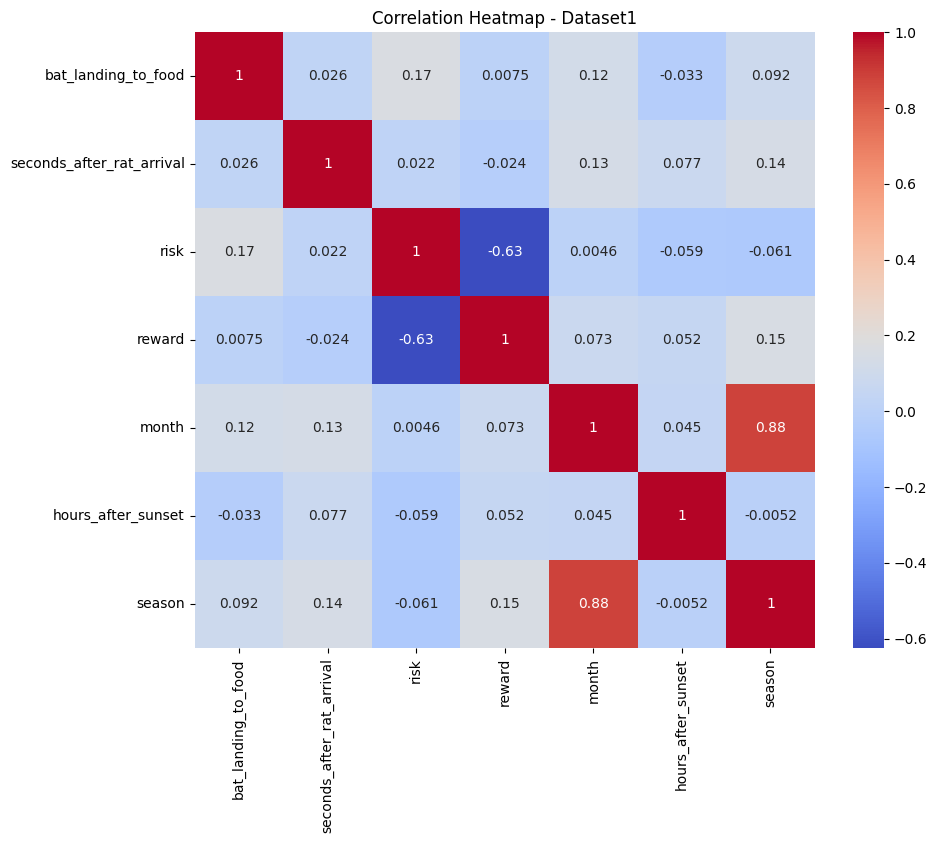

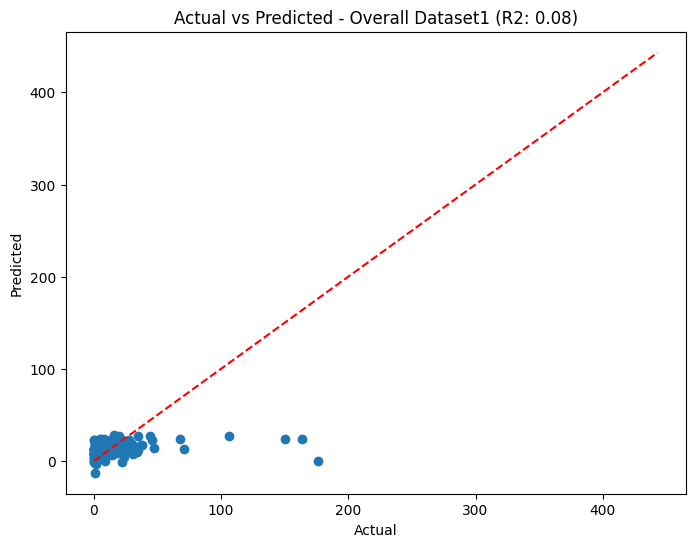

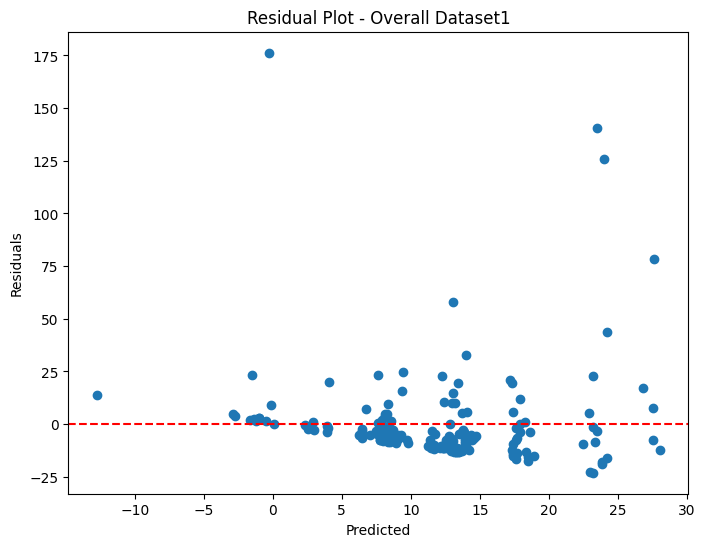

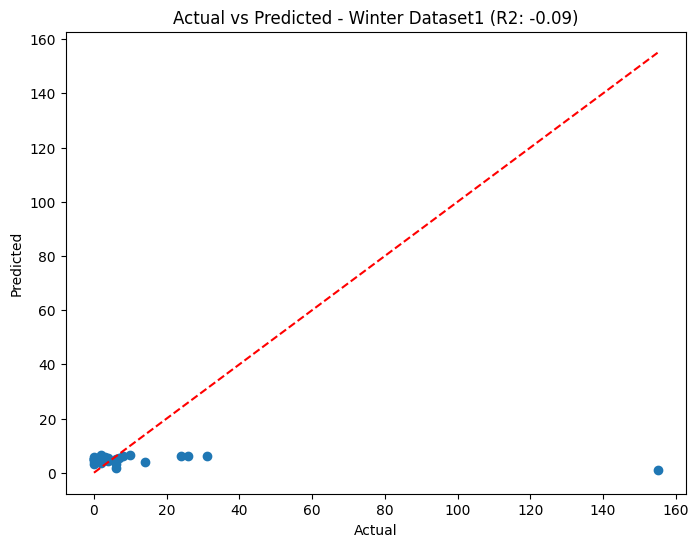

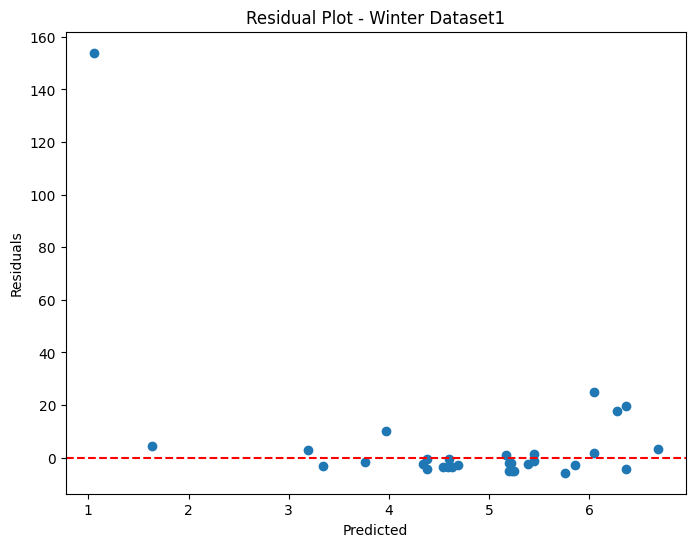

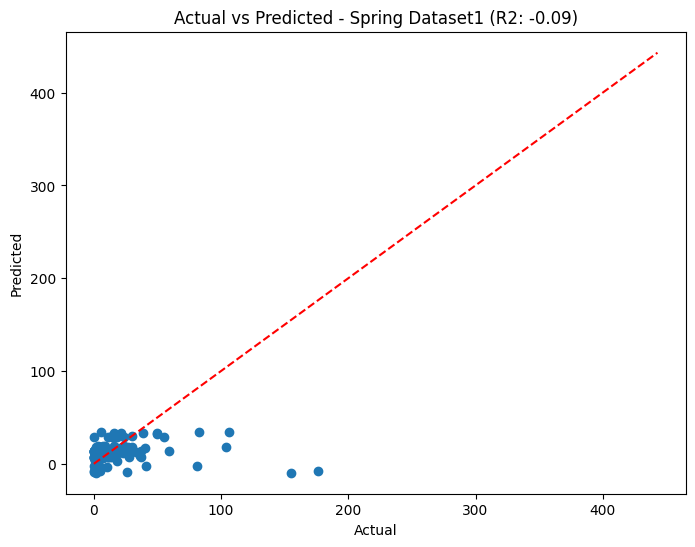

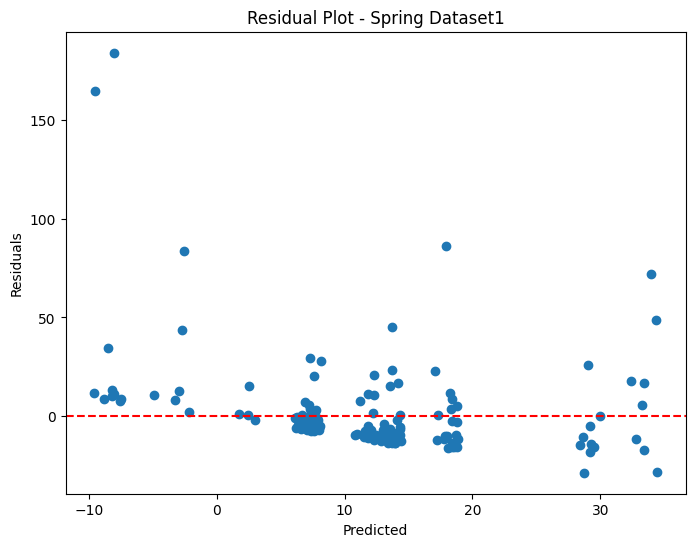

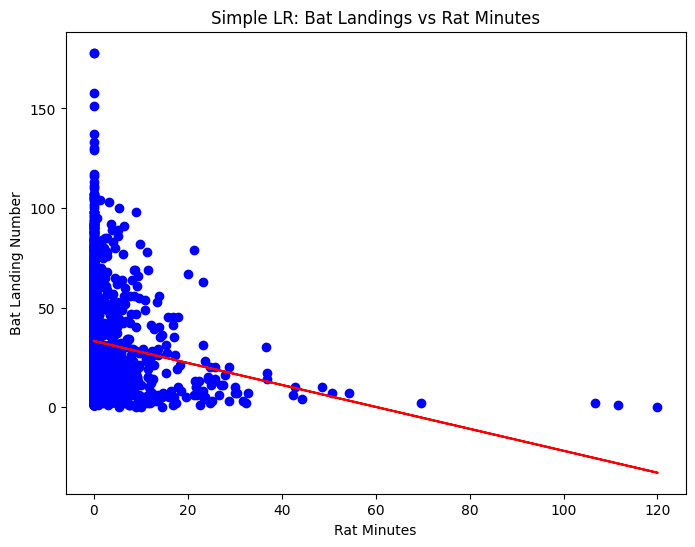

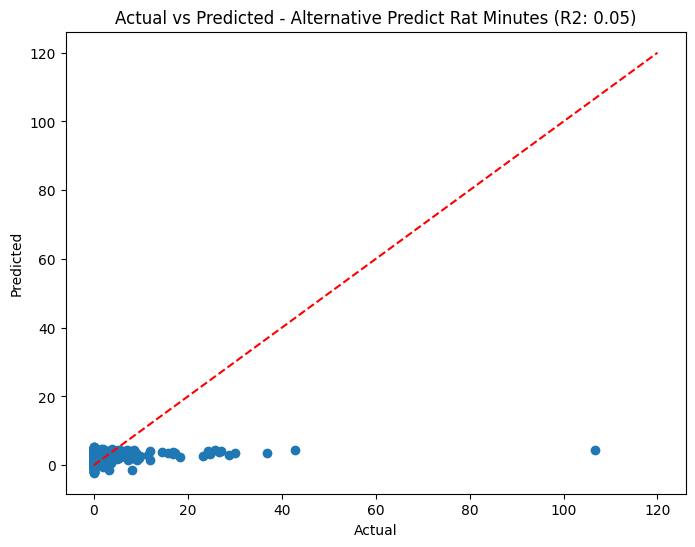

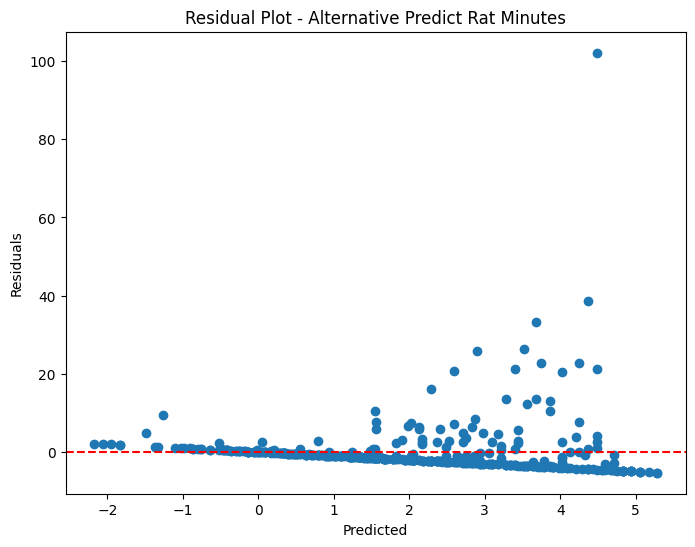

In [13]:
#Linear Regression

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

dataset2_path = '/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset2_cleaned.csv'
dataset1_path = '/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset1_cleaned.csv'

#Loading datasets
df2 = pd.read_csv(dataset2_path, parse_dates=['time'])
df1 = pd.read_csv(dataset1_path, parse_dates=['start_time', 'rat_period_start', 'rat_period_end', 'sunset_time'])

#Drop the non-numeric columns for LR
df2_numeric = df2.select_dtypes(include=['float64', 'int64'])
df1_numeric = df1.select_dtypes(include=['float64', 'int64'])

#Function for multiple Llinear Regression with visualization
def run_lr_with_viz(X, y, title, test_size=0.2):
    if len(X) < 2:
        print("Sample too small for", title)
        return None, None, None, None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    #Visualization for "Actual vs Predicted scatter"
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted - {title} (R2: {r2:.2f})')
    plt.show()

    #Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {title}')
    plt.show()

    return model.coef_, model.intercept_, r2, list(zip(X.columns, model.coef_))

#Correlation heatmap for Dataset2
plt.figure(figsize=(10, 8))
sns.heatmap(df2_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Dataset2')
plt.show()

#1. Overall Multiple Linear Regression on Dataset2: Predict bat_landing_number
X2 = df2_numeric.drop('bat_landing_number', axis=1)
y2 = df2_numeric['bat_landing_number']
coef2, intercept2, r22, coef_zip2 = run_lr_with_viz(X2, y2, 'Overall Dataset2')

#2. Seasonal for Dataset2
winter2 = df2[df2['month'] <= 2]
spring2 = df2[df2['month'] >= 3]
X_w2 = winter2.select_dtypes(include=['float64', 'int64']).drop('bat_landing_number', axis=1)
y_w2 = winter2['bat_landing_number']
coef_w2, intercept_w2, r2_w2, coef_zip_w2 = run_lr_with_viz(X_w2, y_w2, 'Winter Dataset2')

X_s2 = spring2.select_dtypes(include=['float64', 'int64']).drop('bat_landing_number', axis=1)
y_s2 = spring2['bat_landing_number']
coef_s2, intercept_s2, r2_s2, coef_zip_s2 = run_lr_with_viz(X_s2, y_s2, 'Spring Dataset2')

#Correlation heatmap for Dataset1
plt.figure(figsize=(10, 8))
sns.heatmap(df1_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Dataset1')
plt.show()

#3. Overall Multiple LR on Dataset1: Predict bat_landing_to_food
X1 = df1_numeric.drop('bat_landing_to_food', axis=1)
y1 = df1_numeric['bat_landing_to_food']
coef1, intercept1, r21, coef_zip1 = run_lr_with_viz(X1, y1, 'Overall Dataset1')

#4. Seasonal for Dataset1
winter1 = df1[df1['month'] <= 2]
spring1 = df1[df1['month'] >= 3]
X_w1 = winter1.select_dtypes(include=['float64', 'int64']).drop('bat_landing_to_food', axis=1)
y_w1 = winter1['bat_landing_to_food']
coef_w1, intercept_w1, r2_w1, coef_zip_w1 = run_lr_with_viz(X_w1, y_w1, 'Winter Dataset1')

X_s1 = spring1.select_dtypes(include=['float64', 'int64']).drop('bat_landing_to_food', axis=1)
y_s1 = spring1['bat_landing_to_food']
coef_s1, intercept_s1, r2_s1, coef_zip_s1 = run_lr_with_viz(X_s1, y_s1, 'Spring Dataset1')

#5. Simple LR: bat_landing_number vs rat_minutes (Dataset2) with viz
X_simple = df2[['rat_minutes']]
y_simple = df2['bat_landing_number']
model_simple = LinearRegression()
model_simple.fit(X_simple, y_simple)
y_pred_simple = model_simple.predict(X_simple)

plt.figure(figsize=(8, 6))
plt.scatter(X_simple, y_simple, color='blue')
plt.plot(X_simple, y_pred_simple, color='red')
plt.xlabel('Rat Minutes')
plt.ylabel('Bat Landing Number')
plt.title('Simple LR: Bat Landings vs Rat Minutes')
plt.show()

#6. Alternative: Predict rat_minutes from time vars (Dataset2) with viz
X_alt = df2[['hours_after_sunset', 'month']]
y_alt = df2['rat_minutes']
coef_alt, intercept_alt, r2_alt, coef_zip_alt = run_lr_with_viz(X_alt, y_alt, 'Alternative Predict Rat Minutes')

OLS Summary for Investigation A:
                            OLS Regression Results                            
Dep. Variable:     bat_landing_number   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     122.6
Date:                Tue, 14 Oct 2025   Prob (F-statistic):          1.45e-185
Time:                        13:21:15   Log-Likelihood:                -9451.2
No. Observations:                2123   AIC:                         1.892e+04
Df Residuals:                    2113   BIC:                         1.898e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
con

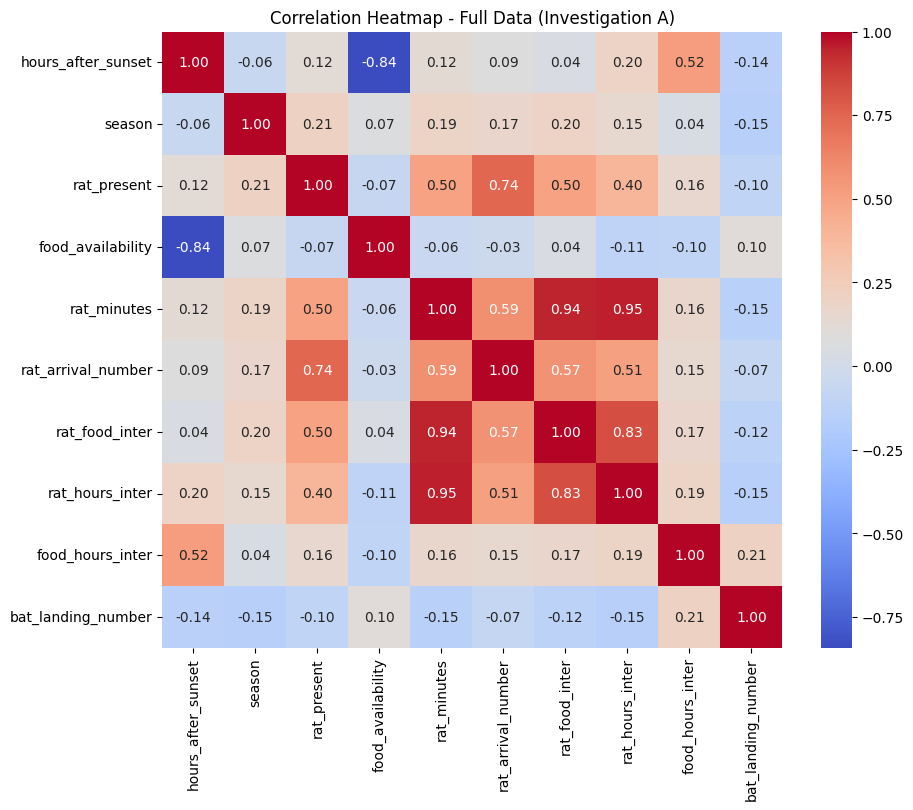


OLS Summary for Winter (Investigation B):
                            OLS Regression Results                            
Dep. Variable:     bat_landing_number   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     68.73
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           2.29e-87
Time:                        13:21:16   Log-Likelihood:                -3862.0
No. Observations:                 880   AIC:                             7742.
Df Residuals:                     871   BIC:                             7785.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

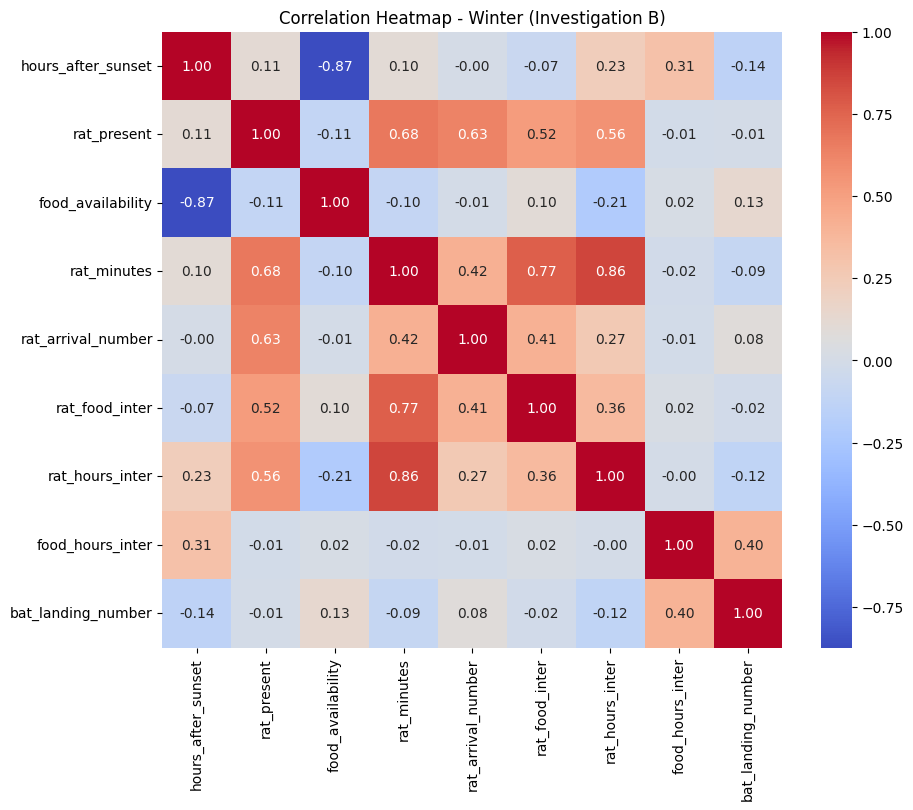


OLS Summary for Spring (Investigation B):
                            OLS Regression Results                            
Dep. Variable:     bat_landing_number   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     76.59
Date:                Tue, 14 Oct 2025   Prob (F-statistic):          1.36e-102
Time:                        13:21:17   Log-Likelihood:                -5543.5
No. Observations:                1243   AIC:                         1.110e+04
Df Residuals:                    1234   BIC:                         1.115e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

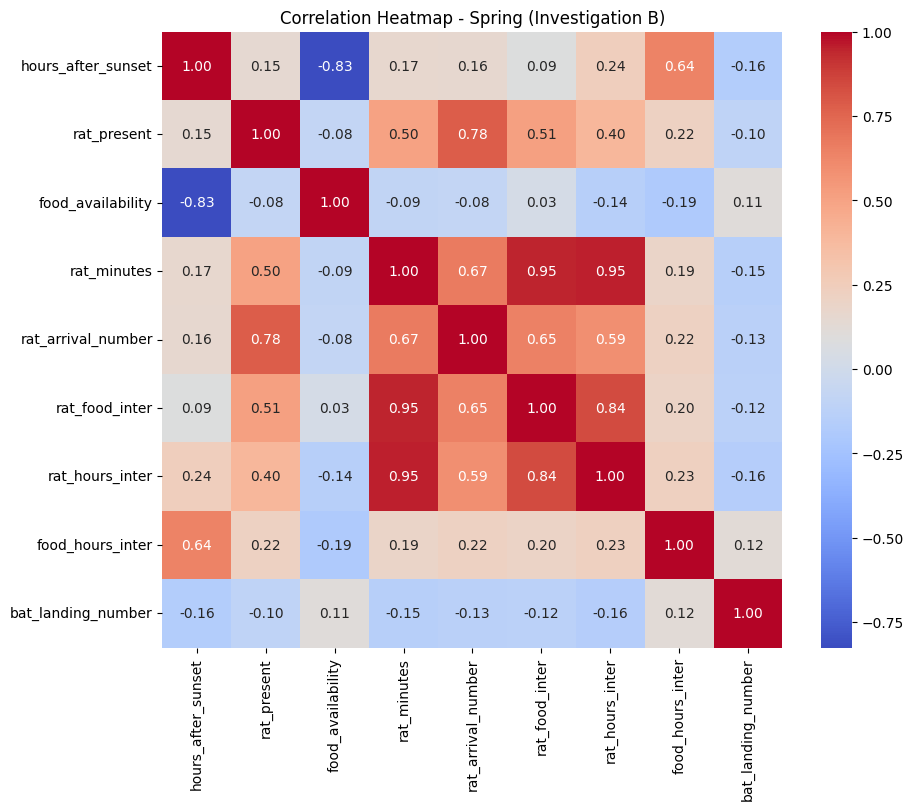


Coefficient Comparison:
                       Winter     Spring
const               36.351108  30.549133
hours_after_sunset -29.790679 -47.248697
rat_present          2.775388  -5.304261
food_availability  -23.154614 -31.233750
rat_minutes          2.296770   2.132467
rat_arrival_number   2.734037  -1.650797
rat_food_inter      -3.048551  -1.981340
rat_hours_inter     -3.309697  -2.034770
food_hours_inter    19.988986  28.594203

Conclusion for Investigation A: Based on the OLS summary and visualizations, bat landing number is significantly influenced by several factors including hours after sunset, season, rat presence, and food availability. The negative coefficient for rat_minutes and rat_arrival_number, coupled with the boxplot showing lower bat landings when rats are present, supports the hypothesis that bats perceive rats as potential predators and reduce their activity when rats are around.

Conclusion for Investigation B: The seasonal analysis reveals distinct patterns. In Wi

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

#Load datasets from file paths
#Here, we have imported and read the two cleaned data files into Python. df2 has info data of the bat landings and rat times and df1 has data about seasons.
df2 = pd.read_csv('/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset2_cleaned.csv')
df2['time'] = pd.to_datetime(df2['time'])  # We convert the 'time' column to a date format

df1 = pd.read_csv('/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/Assessment 3/dataset1_cleaned.csv')
df1['start_time'] = pd.to_datetime(df1['start_time'])  #Converting 'start_time' to a proper date format.

#Feature Engineering: Extract unique month-season mapping from dataset1
#We made a lookup table from df1 that connects each month to its season, without duplicates.
season_map = df1[['month', 'season']].drop_duplicates().set_index('month')['season']

#Merged season into dataset2 on month 
#We combined the season info from df1 into df2 by matching on the 'month' column accordingly, keeping all rows from df2.
df = pd.merge(df2, season_map.reset_index(), on='month', how='left')

#Handled any missing seasons (e.g., for month 6, assume spring=1 based on pattern)
#If there's no season for month 6, we assumed it to be spring (1) based on the pattern; otherwise, kept what's there.
df['season'] = df.apply(lambda row: 1 if pd.isna(row['season']) and row['month'] == 6 else row['season'], axis=1)

#Converted season to integer type
#We changed 'season' to a number type so it's simpler to use
df['season'] = df['season'].astype(int)

#Engineered features
#We create new columns: one to show if rats are there (1) or not (0), and some combinations like rat time times food to see interactions.
df['rat_present'] = (df['rat_minutes'] > 0).astype(int)
df['rat_food_inter'] = df['rat_minutes'] * df['food_availability']
df['rat_hours_inter'] = df['rat_minutes'] * df['hours_after_sunset']
df['food_hours_inter'] = df['food_availability'] * df['hours_after_sunset']

#Select variables for Investigation A
#We picked the columns we'll use to explain bat landings (the main thing we're predicting) for the first question.
explanatory_vars_a = ['hours_after_sunset', 'season', 'rat_present', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'rat_food_inter', 'rat_hours_inter', 'food_hours_inter']
response_var_a = 'bat_landing_number'
df_a = df[explanatory_vars_a + [response_var_a]].dropna()  
#We made a smaller table with just these columns and removed any rows with missing info.

#Standardized continuous variables to remove biases for Investigation A
#We used a tool to make the number columns have similar sizes (average 0, spread 1)
scaler_a = StandardScaler()
continuous_vars_a = ['hours_after_sunset', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'rat_food_inter', 'rat_hours_inter', 'food_hours_inter']
df_a[continuous_vars_a] = scaler_a.fit_transform(df_a[continuous_vars_a])

#Investigation A: Full LR
#We added a starting point (constant) to our explaining columns, then built a model to predict bat landings from them.
X_a = sm.add_constant(df_a[explanatory_vars_a])
y_a = df_a[response_var_a]
model_a = sm.OLS(y_a, X_a).fit()
print("OLS Summary for Investigation A:")
print(model_a.summary())

#Collinearity check for A
#We created a table to check if our explaining columns are too similar to each other.
vif_a = pd.DataFrame()
vif_a['feature'] = X_a.columns
vif_a['VIF'] = [variance_inflation_factor(X_a.values, i) for i in range(X_a.shape[1])]  
#This calculates a score for each. High scores mean too much overlap.
print("\nVIF for Investigation A:")
print(vif_a)

#Visualizations for A (Heatmap only)
plt.figure(figsize=(10,8))
sns.heatmap(df_a[explanatory_vars_a + [response_var_a]].corr(), annot=True, cmap='coolwarm', fmt='.2f')  
# Corr() finds relations, heatmap draws it with numbers.
plt.title('Correlation Heatmap - Full Data (Investigation A)')
plt.show()  


#Investigation B: Split by season
#We made separate copies of the data for winter (season 0) and spring (season 1) to compare them.
df_winter = df[df['season'] == 0].copy()
df_spring = df[df['season'] == 1].copy()

#Select variables for Investigation B (excluding season for seasonal models)
#We choose similar columns but skip 'season' since we're looking at each season separately.
explanatory_vars_b = ['hours_after_sunset', 'rat_present', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'rat_food_inter', 'rat_hours_inter', 'food_hours_inter']
response_var_b = 'bat_landing_number'

#Standardized continuous variables for Winter (Investigation B)
#Same as done above, but just for winter data
scaler_w = StandardScaler()
continuous_vars_b = ['hours_after_sunset', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'rat_food_inter', 'rat_hours_inter', 'food_hours_inter']
df_winter[continuous_vars_b] = scaler_w.fit_transform(df_winter[continuous_vars_b])
df_winter = df_winter.dropna()  # Remove any missing rows.

#Winter LR (exclude season)
#If there's data, build and show the model for winter.
if not df_winter.empty:
    X_w = sm.add_constant(df_winter[explanatory_vars_b])
    y_w = df_winter[response_var_b]
    model_w = sm.OLS(y_w, X_w).fit()
    print("\nOLS Summary for Winter (Investigation B):")
    print(model_w.summary())

    #Visualizations for Winter (B) - Heatmap only
    #Make a relation grid just for winter data.
    plt.figure(figsize=(10,8))
    sns.heatmap(df_winter[explanatory_vars_b + [response_var_b]].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap - Winter (Investigation B)')
    plt.show()
else:
    print("\nNo data for Winter (Investigation B) after dropping NaNs.")

#Standardized continuous variables for Spring (Investigation B)
#Same standardization, but for spring data.
scaler_s = StandardScaler()
df_spring[continuous_vars_b] = scaler_s.fit_transform(df_spring[continuous_vars_b])
df_spring = df_spring.dropna()

#Spring LR (exclude season)
#If there's data, build and show the model for spring.
if not df_spring.empty:
    X_s = sm.add_constant(df_spring[explanatory_vars_b])
    y_s = df_spring[response_var_b]
    model_s = sm.OLS(y_s, X_s).fit()
    print("\nOLS Summary for Spring (Investigation B):")
    print(model_s.summary())

    #Visualizations for Spring (B) Heatmap only
    #Make a relation grid just for spring data.
    plt.figure(figsize=(10,8))
    sns.heatmap(df_spring[explanatory_vars_b + [response_var_b]].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap - Spring (Investigation B)')
    plt.show()
else:
     print("\nNo data for Spring (Investigation B) after dropping NaNs.")

#Coefficient comparison (if both seasonal models ran)
#If both models worked, make a table comparing their numbers (coefficients) side by side.
if not df_winter.empty and not df_spring.empty:
    coeff_comp = pd.DataFrame({
        'Winter': model_w.params,
        'Spring': model_s.params
    }).fillna(0)  # Fill any missing spots with 0.
    print("\nCoefficient Comparison:")
    print(coeff_comp)

#Conclusions (printed as output)
#These are the summaries of what we learned from the models and charts.
print("\nConclusion for Investigation A: Based on the OLS summary and visualizations, bat landing number is significantly influenced by several factors including hours after sunset, season, rat presence, and food availability. The negative coefficient for rat_minutes and rat_arrival_number, coupled with the boxplot showing lower bat landings when rats are present, supports the hypothesis that bats perceive rats as potential predators and reduce their activity when rats are around.")

print("\nConclusion for Investigation B: The seasonal analysis reveals distinct patterns. In Winter, the relationship between bat landings and rat presence appears less negative (or even positive), suggesting a higher tolerance or different interaction dynamics. In Spring, the negative relationship between bat landings and rat presence is more pronounced, indicating stronger avoidance behavior, likely driven by increased resource competition and higher activity levels of both species.")